<a href="https://colab.research.google.com/github/alfa7g7/Fundamentos-analitica-II/blob/main/Clase%201/Ejercicio%20en%20clase.-20240802/fundamentos_de_anal%C3%ADtica_clase1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. Carga de paquetes**

In [1]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error


Este documento presenta una breve introducción a la construcción de objetos de series de tiempo y el cálculo de pronósticos con modelos de suavización.

Para este ejercicio emplearemos la información disponible en el archivo datosEmpleo.xlsx. En ese archivo econtrarán la tasa de desempleo mensual de las 13 principales ciudades en Colombia (Ocupados13ciudades). El archivo también contiene series mensuales para las 13 principales ciudades de Colombia el número de ocupados en miles de personas (Ocupados), los desocupados (Desocupados) y los inactivos (Inactivos).

## **2. Carga de datos**

Nuestra primera tarea será leer el archivo de Excel. Para eso podemos emplear el paquete Pandas. Carguemos los datos en un objeto que denominaremos data.

In [2]:
data = pd.read_excel(r'https://github.com/alfa7g7/Fundamentos-analitica-II/raw/main/Clase%201/Ejercicio%20en%20clase.-20240802/datosEmpleo.xlsx', index_col='mes', parse_dates=True)

data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


En este caso los datos fueron leídos como un data frame y adicionalmente la columna "mes" fue seleccionada como indice, con el dataframe de esta forma sera más facil trabajar las series de tiempo.

A continuación se gráfica la tasa de desempleo.



(220, 4)


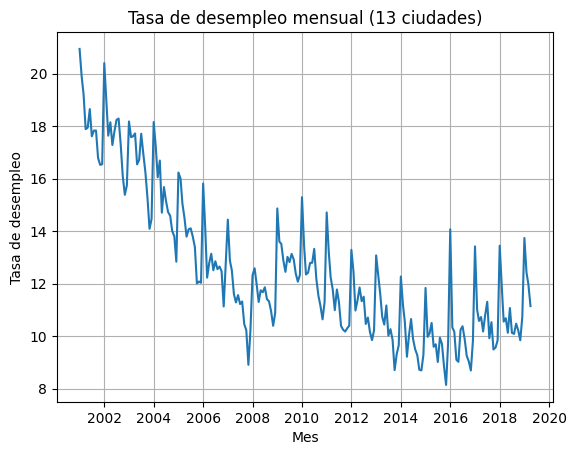

In [3]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos
plt.title("Tasa de desempleo mensual (13 ciudades)")
plt.xlabel("Mes")
plt.ylabel("Tasa de desempleo")
plt.plot(data[["Ocupados"]])
plt.grid()
plt.show()

## **3. Encontrando los componentes de una serie de tiempo**

En algunas ocasiones puede ser útil empezar nuestro análisis descomponiendo la serie de tiempo en sus componentes: **tendencia**, **estacionalidad** y **componente puramente aleatorio**. Una forma de hacer esto es empleando la función seasonal_decompose.

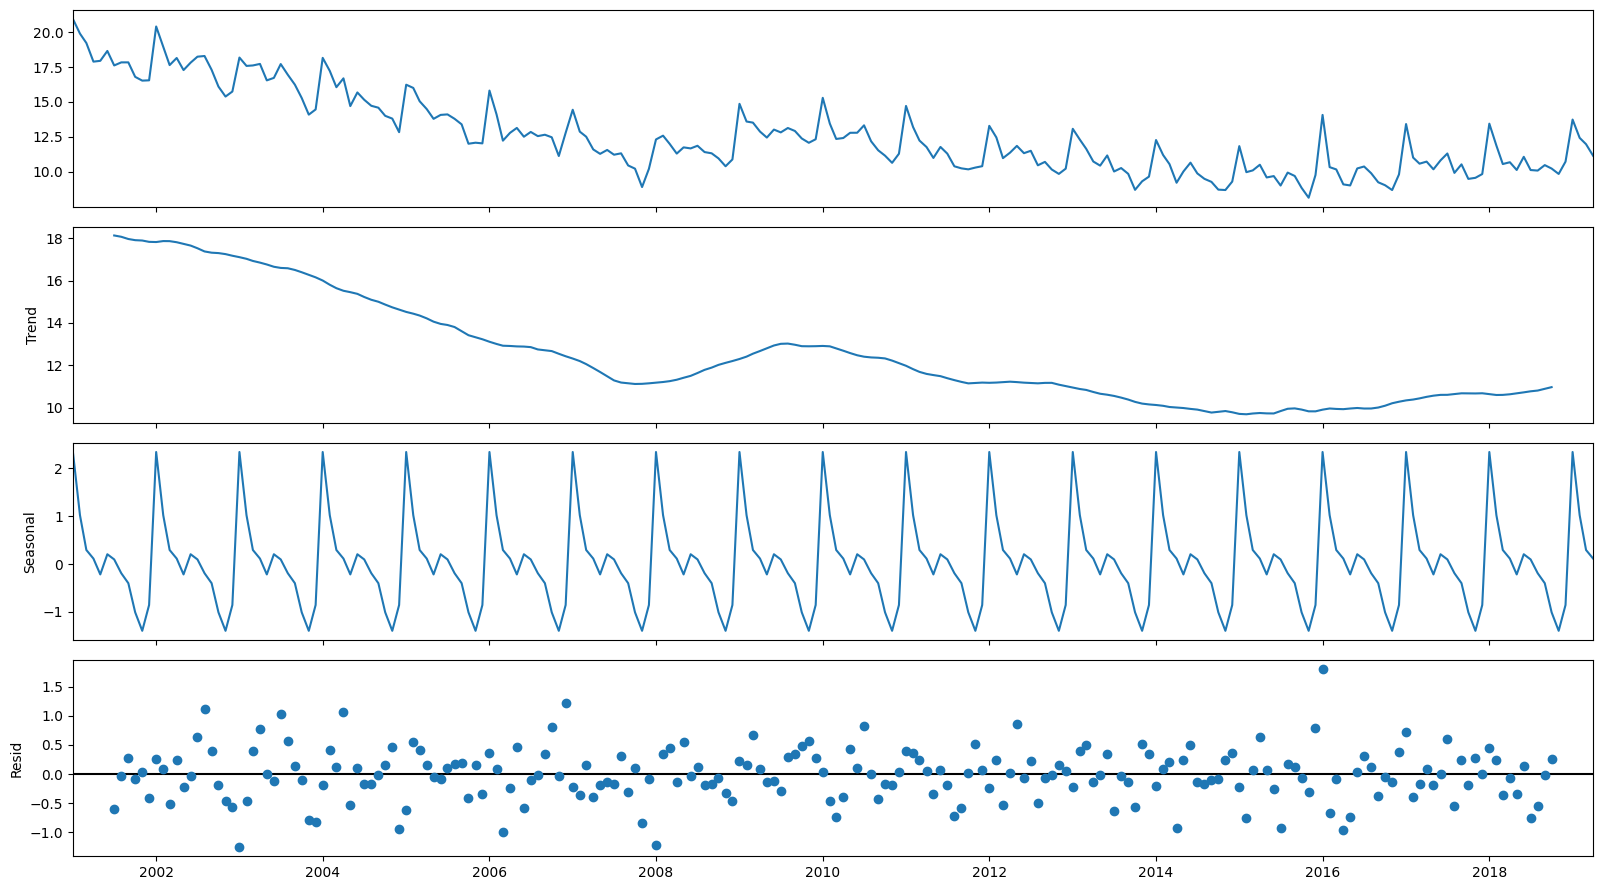

In [4]:
td_componentes = seasonal_decompose(data[["TD_13ciudades"]],model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

Asi se extrae cada elemento de la descomposición de la serie.

In [5]:
td_componentes.seasonal
#td_componentes.trend
#td_componentes.resid

mes
2001-01-01    2.341068
2001-02-01    1.020286
2001-03-01    0.293373
2001-04-01    0.113895
2001-05-01   -0.217028
                ...   
2018-12-01   -0.856036
2019-01-01    2.341068
2019-02-01    1.020286
2019-03-01    0.293373
2019-04-01    0.113895
Name: seasonal, Length: 220, dtype: float64

Podemos observar el componente estacional marcado en la serie, una tendencia no lineal de los datos y la parte aleatoria.

Es importante mencionar que esta descomposición se emplea solo como referencia para iniciar el análisis.

Antes de entrar a trabajar con los métodos de suavizamiento, vale la pena anotar que una forma sencilla y rápida para quitar el componente estacional (desestacionalizar) es restarle a la serie el componente estacional encontrado en la descomposición. Es decir,

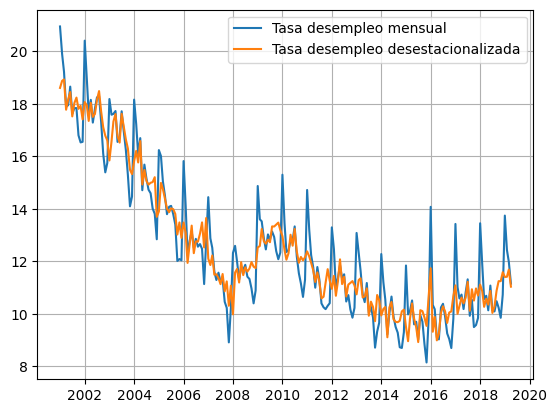

In [6]:
td_desestacionalizada = data["TD_13ciudades"]-td_componentes.seasonal

plt.plot(data[["TD_13ciudades"]],label="Tasa desempleo mensual")
plt.plot(td_desestacionalizada,label="Tasa desempleo desestacionalizada")
plt.legend()
plt.grid()
plt.show()


## **4. Pronosticando metodos de suavización**

Antes de continuar es importante guardar una parte de la muestra para evaluar el comportamiento de los modelos por fuera de muestra (out-of-sample). Guardemos un año de datos.

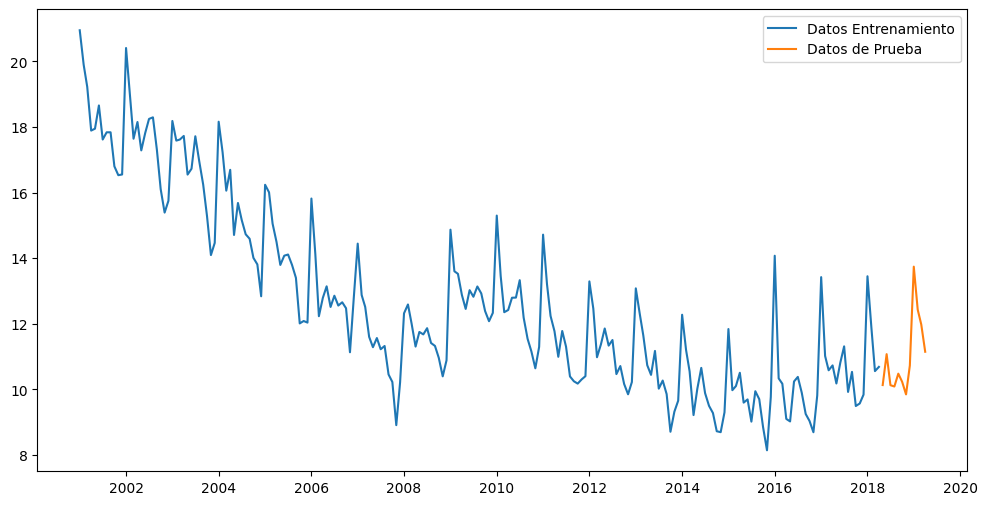

In [7]:
train_len = 208
train_td = data[["TD_13ciudades"]][:train_len]
test_td = data[["TD_13ciudades"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(test_td,label="Datos de Prueba")
plt.legend()
plt.show()

In [8]:
train_td

,TD_13ciudades
mes,
2001-01-01,20.946380
2001-02-01,19.894213
2001-03-01,19.221565
2001-04-01,17.888575
2001-05-01,17.945654
...,...
2017-12-01,9.837395
2018-01-01,13.446245
2018-02-01,11.874973


In [9]:
test_td

,TD_13ciudades
mes,
2018-05-01,10.129211
2018-06-01,11.071347
2018-07-01,10.125100
2018-08-01,10.085244
2018-09-01,10.476567
2018-10-01,10.230811
2018-11-01,9.844539
2018-12-01,10.725865
2019-01-01,13.739328


### **4.1 Promedio movil**

El promedio móvil está dado por:

$$ F_{t + 1}=\frac{Y_{t} + Y_{t-1} + Y_{t-(k-1)} }{ k} $$

El método de los promedios móviles utiliza el promedio de los $k$
valores de datos más recientes en la serie de tiempo como el
pronóstico para el siguiente periodo.

El término móvil indica que, mientras se dispone de una nueva
observación para la serie de tiempo, reemplaza a la observación más
antigua de la ecuación anterior y se calcula un promedio nuevo.
Como resultado, el promedio cambiará, o se moverá, conforme surjan
nuevas observaciones.

$Y_{t}$ = Observación en el período t

$F_{t}$ = Pronóstico en el período t

In [10]:
## Considerando el dato actual
ma_2= train_td.rolling(2,min_periods=2).mean()
ma_3= train_td.rolling(3,min_periods=2).mean()
ma_4= train_td.rolling(4,min_periods=2).mean()
ma_5= train_td.rolling(5,min_periods=2).mean()

In [11]:
## Sin considerar el dato actual
ma_2= train_td.shift().rolling(2,min_periods=2).mean()
ma_3= train_td.shift().rolling(3,min_periods=2).mean()
ma_4= train_td.shift().rolling(4,min_periods=2).mean()
ma_5= train_td.shift().rolling(5,min_periods=2).mean()


In [12]:
def fore_ma(datos,w,h): #w es la ventana del promedio para hacer el pronostico (10,15,20,25,30) w=2 (10 con 15, 15 con 20, 20 con 25) w=3 (10 con 15 con 20, )..., h el num de pronosticos hacia adelante
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
  return data[-h:]

In [13]:
ma_2_f= fore_ma(train_td,2,12)
ma_3_f= fore_ma(train_td,3,12)
ma_4_f= fore_ma(train_td,4,12)
ma_5_f= fore_ma(train_td,5,12)

In [14]:
rmse_ma_2 = np.sqrt(mean_squared_error(test_td,ma_2_f ))
rmse_ma_3 = np.sqrt(mean_squared_error(test_td,ma_3_f ))
rmse_ma_4 = np.sqrt(mean_squared_error(test_td,ma_4_f ))
rmse_ma_5 = np.sqrt(mean_squared_error(test_td,ma_5_f ))

In [15]:
print( rmse_ma_2, rmse_ma_3 ,rmse_ma_4 ,rmse_ma_5)

1.1781369446057537 1.149344676431958 1.167290983502916 1.1536277219669278


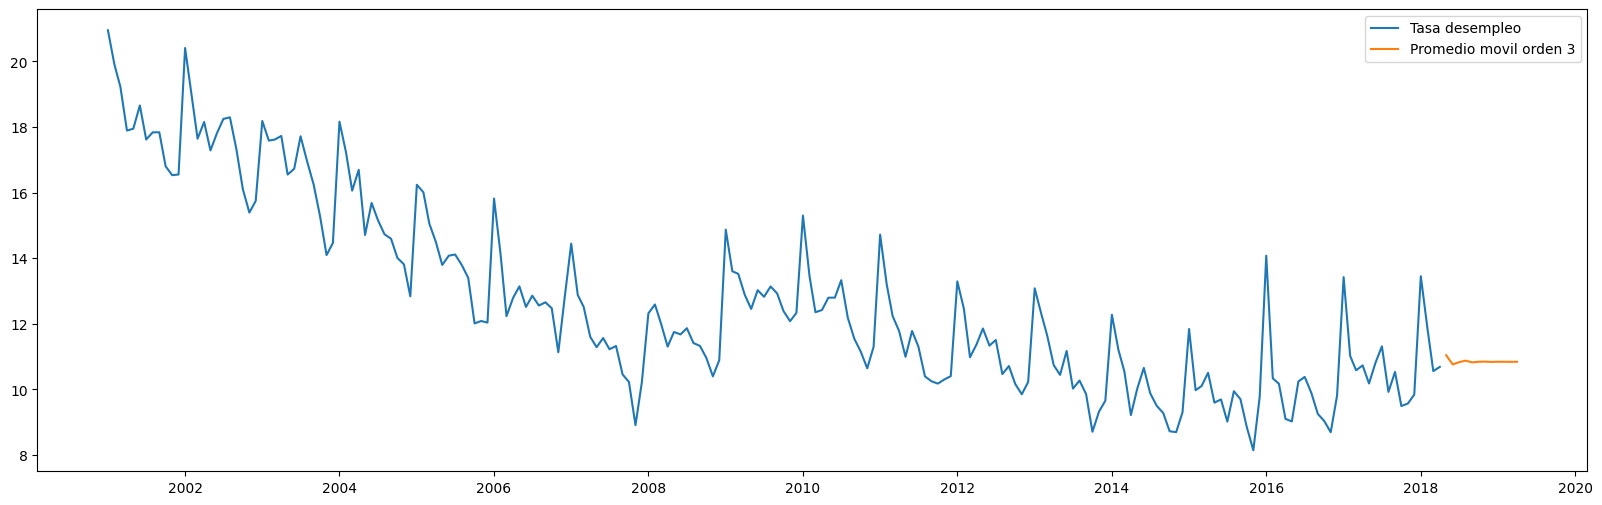

In [16]:
fig = plt.figure(figsize=(20, 6))
plt.plot(train_td,label="Tasa desempleo")
plt.plot(ma_3_f,label="Promedio movil orden 3")
plt.legend()
plt.show()

### **4.2 Suavizacion Exponencial Simple**

In [17]:
# Build model.
ets_model = ETSModel(endog=train_td["TD_13ciudades"],error="add")#,trend="add",seasonal="mul" ) error: es el alfa adictivo o multiplicativo
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds = pd.concat([limits, conf_forecast], axis = 1)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

            Point_forecast  lower_95   upper_95
2018-05-01       10.959788  8.650409  13.269166
2018-06-01       10.959788  8.505554  13.414022
2018-07-01       10.959788  8.368785  13.550791
2018-08-01       10.959788  8.238882  13.680694
2018-09-01       10.959788  8.114904  13.804672
2018-10-01       10.959788  7.996108  13.923468
2018-11-01       10.959788  7.881894  14.037682
2018-12-01       10.959788  7.771769  14.147807
2019-01-01       10.959788  7.665323  14.254253
2019-02-01       10.959788  7.562210  14.357366
2019-03-01       10.959788  7.462136  14.457440
2019-04-01       10.959788  7.364847  14.554729


C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


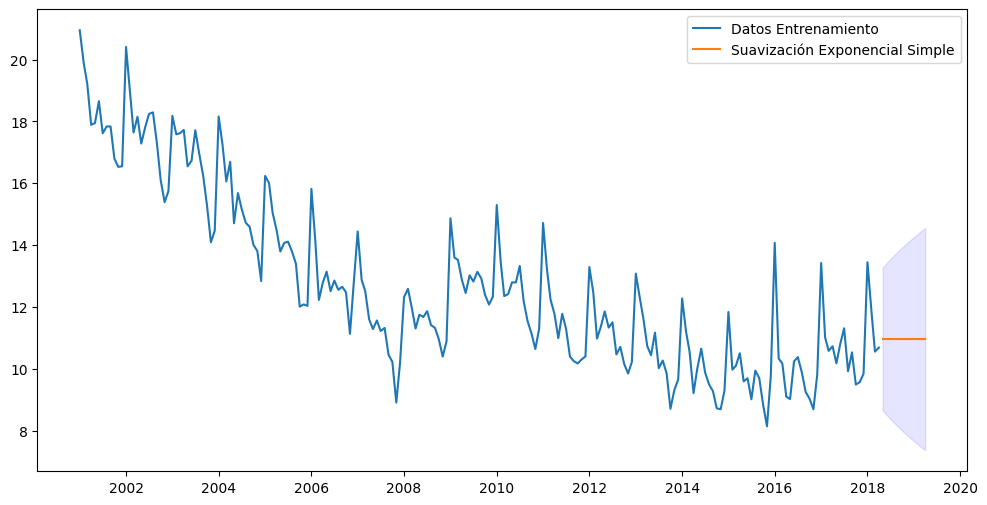

In [18]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(preds.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

En esta caso el α estimado es 0.3596639.Y el RMSE en la muestra de evaluación es 1.12

In [19]:
ets_result.alpha

0.35969977150507815

In [20]:
rmse = np.sqrt(mean_squared_error(test_td,point_forecast ))
print(rmse)

1.124421772293525


### **4.3 Suavizacion Exponencial Lineal (Holt)**

In [21]:
# Build model.
ets_model = ETSModel(endog=train_td["TD_13ciudades"],error="mul",trend="mul")#,seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_holt = pd.concat([limits, conf_forecast], axis = 1)
preds_holt.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_holt)

            Point_forecast  lower_95   upper_95
2018-05-01       10.660582  8.603310  12.874334
2018-06-01       10.632885  8.442853  12.800173
2018-07-01       10.605260  8.492713  12.738293
2018-08-01       10.577707  8.323227  12.900199
2018-09-01       10.550225  8.191179  12.677888
2018-10-01       10.522815  8.214143  12.734340
2018-11-01       10.495476  8.407167  12.780479
2018-12-01       10.468208  8.275852  12.865677
2019-01-01       10.441010  8.209253  12.635147
2019-02-01       10.413884  8.106284  13.064016
2019-03-01       10.386828  8.088210  12.897568
2019-04-01       10.359842  8.009382  12.772378


C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


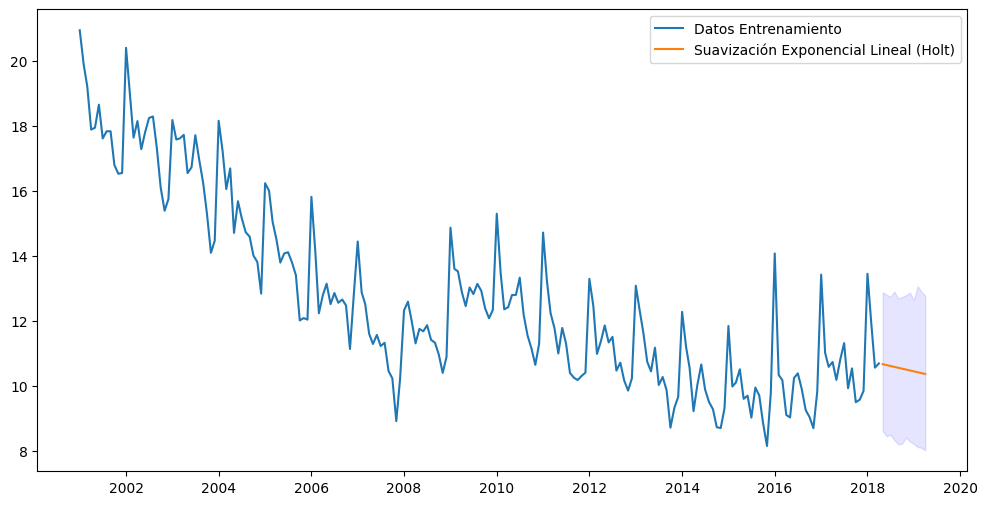

In [22]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_holt['Point_forecast'],label="Suavización Exponencial Lineal (Holt)")
plt.fill_between(preds_holt.index ,preds_holt['lower_95'], preds_holt['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

En esta caso el α estimado es 0.17153975893378887 y el β estimado es 1.7153975893378887$^{-5}$. Y el RMSE en la muestra de evaluación es 1.2780044501304348.

In [23]:
print(ets_result.alpha,ets_result.beta)

0.1715370923131306 1.7153709231313062e-05


In [24]:
rmse_holt = np.sqrt(mean_squared_error(test_td,preds_holt['Point_forecast']))
print(rmse_holt)

1.2780066450538032


## **4.3 Suavizacion Exponencial Lineal de Winters (Holt-Winters)**

In [25]:
# Build model
ets_model = ETSModel(endog=train_td["TD_13ciudades"],error="add",trend="add",seasonal="add" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

            Point_forecast   lower_95   upper_95
2018-05-01       10.297343   9.251531  11.343154
2018-06-01       10.674326   9.532336  11.816315
2018-07-01       10.565102   9.334411  11.795793
2018-08-01       10.226632   8.913201  11.540064
2018-09-01        9.946453   8.555177  11.337728
2018-10-01        9.282709   7.817706  10.747712
2018-11-01        8.875229   7.340021  10.410437
2018-12-01        9.376622   7.774270  10.978975
2019-01-01       12.534227  10.867420  14.201034
2019-02-01       11.193090   9.464217  12.921963
2019-03-01       10.434280   8.645482  12.223078
2019-04-01       10.158436   8.311645  12.005227


C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


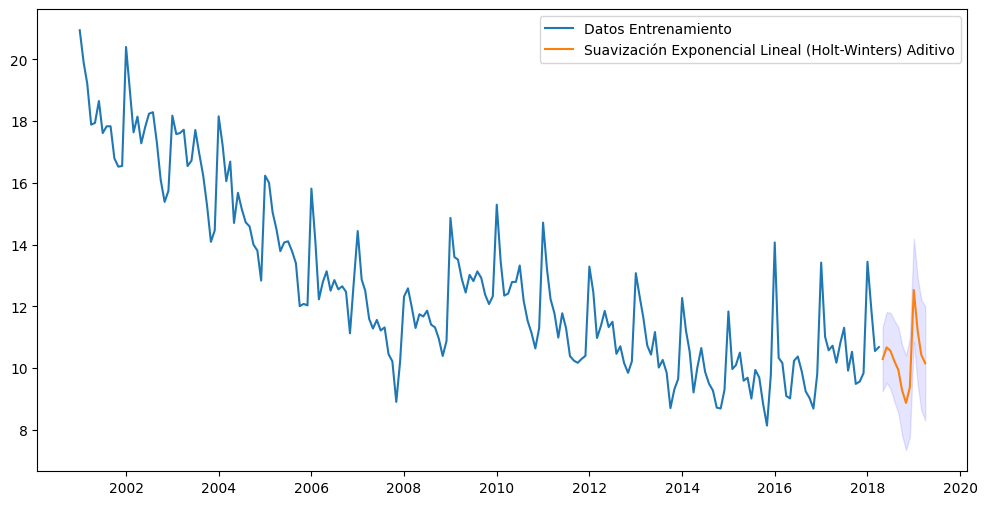

In [26]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_hw_add['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Aditivo")
plt.fill_between(preds_hw_add.index ,preds_hw_add['lower_95'], preds_hw_add['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [27]:
print(ets_result.alpha,ets_result.beta,ets_result.gamma)

0.43857579870448893 4.3857579870448896e-05 5.614242012955111e-05


In [28]:
rmse_hw_add = np.sqrt(mean_squared_error(test_td,preds_hw_add['Point_forecast']))
print(rmse_hw_add)

0.9425697279485371


In [29]:
# Build model.
ets_model = ETSModel(endog=train_td["TD_13ciudades"],error="add",trend=None,seasonal="mul" , )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_mul = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_mul.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_mul)

            Point_forecast   lower_95   upper_95
2018-05-01       10.433036   9.331451  11.444005
2018-06-01       10.981856   9.788340  12.228453
2018-07-01       10.779516   9.475593  12.058811
2018-08-01       10.380956   9.005870  11.781461
2018-09-01       10.300534   8.861983  11.666344
2018-10-01        9.708898   8.181466  11.132564
2018-11-01        9.565507   8.020291  11.061558
2018-12-01       10.265135   8.646958  11.933368
2019-01-01       13.399531  11.381367  15.376386
2019-02-01       11.447407   9.609483  13.276217
2019-03-01       10.843306   8.906785  12.748072
2019-04-01       10.618172   8.567092  12.569689


C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


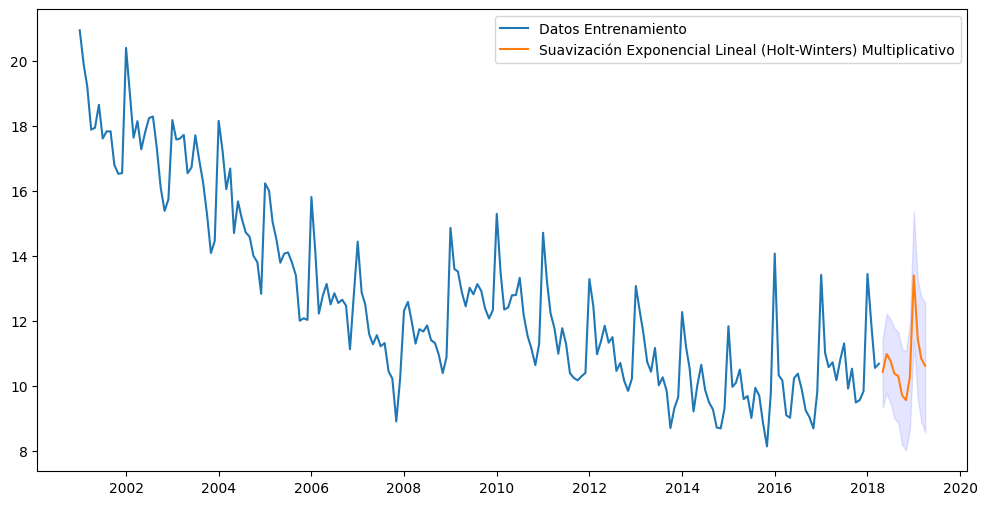

In [30]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_hw_mul['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Multiplicativo")
plt.fill_between(preds_hw_mul.index ,preds_hw_mul['lower_95'], preds_hw_mul['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [31]:
print(ets_result.alpha,ets_result.gamma)

0.4314985227050782 0.1609709018402775


In [32]:
rmse_hw_mul = np.sqrt(mean_squared_error(test_td,preds_hw_mul['Point_forecast']))
print(rmse_hw_mul)

0.5659175481344269


## **5. Ejercicio en Clase**

Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses. Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.

Limitacion> a medida que se aleja del tiempo pierde precision

### 5.1 Definición del cinjunto de datos

In [33]:
data

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911
...,...,...,...,...
2018-12-01,10.725865,10835.398,1301.822,6142.856
2019-01-01,13.739328,10314.438,1642.851,6343.066
2019-02-01,12.427409,10557.917,1498.272,6264.403


### 5.2 Graficamos la variable de Ocupados

(220, 4)


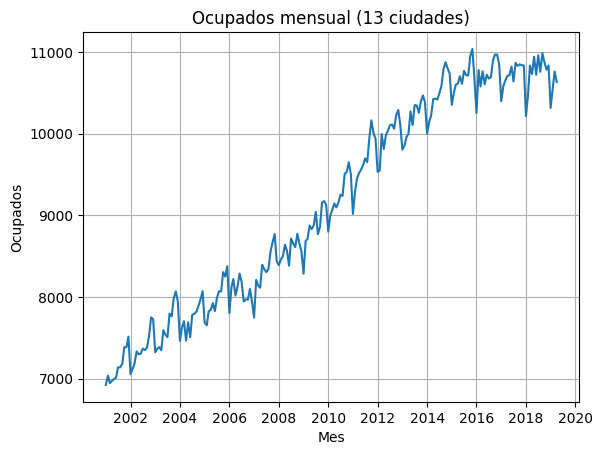

In [40]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos

plt.title("Ocupados mensual (13 ciudades)")
plt.xlabel("Mes")
plt.ylabel("Ocupados")
plt.plot(data[["Ocupados"]])
plt.grid()
plt.show()

### 5.3 Encontramos los componentes de la serie de tiempo

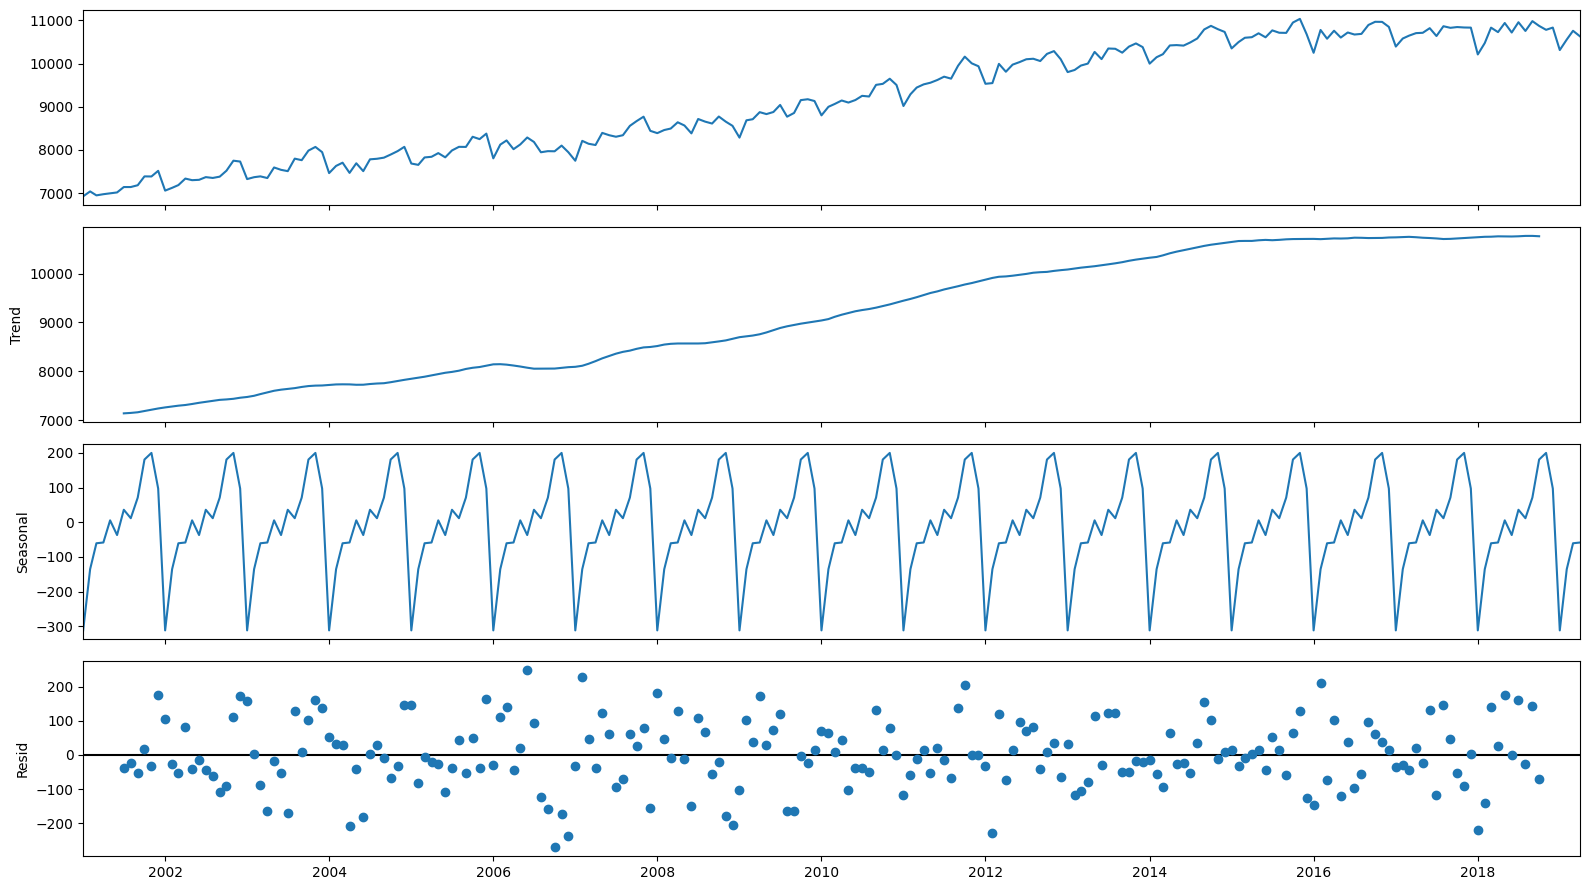

In [42]:
Ocupados_componentes = seasonal_decompose(data[["Ocupados"]],model="additive")
fig = Ocupados_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

Extrayendo cada elemento de la descomposición de la serie

In [43]:
Ocupados_componentes.seasonal
#Ocupados_componentes.trend
#Ocupados_componentes.resid

mes
2001-01-01   -311.454885
2001-02-01   -135.216366
2001-03-01    -60.470657
2001-04-01    -58.270721
2001-05-01      5.551095
                 ...    
2018-12-01     97.140345
2019-01-01   -311.454885
2019-02-01   -135.216366
2019-03-01    -60.470657
2019-04-01    -58.270721
Name: seasonal, Length: 220, dtype: float64

Podemos observar el componente estacional marcado en la serie, una tendencia no lineal de los datos y la parte aleatoria.

Es importante mencionar que esta descomposición se emplea solo como referencia para iniciar el análisis.

Antes de entrar a trabajar con los métodos de suavizamiento, vale la pena anotar que una forma sencilla y rápida para quitar el componente estacional (desestacionalizar) es restarle a la serie el componente estacional encontrado en la descomposición. Es decir,

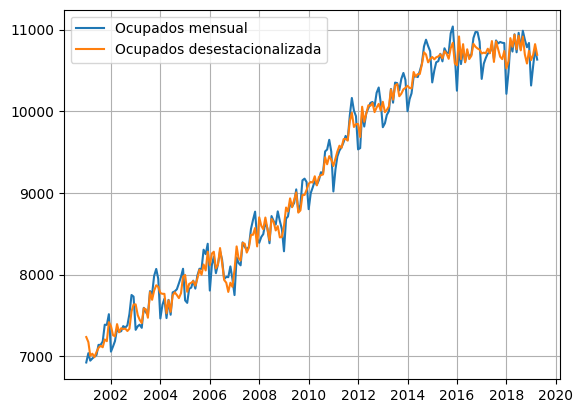

In [44]:
Ocupados_desestacionalizada = data["Ocupados"]-Ocupados_componentes.seasonal

plt.plot(data[["Ocupados"]],label="Ocupados mensual")
plt.plot(Ocupados_desestacionalizada,label="Ocupados desestacionalizada")
plt.legend()
plt.grid()
plt.show()

### 5.4 Pronosticando metodos de suavización

Antes de continuar es importante guardar una parte de la muestra para evaluar el comportamiento de los modelos por fuera de muestra (out-of-sample). Guardemos un año de datos.

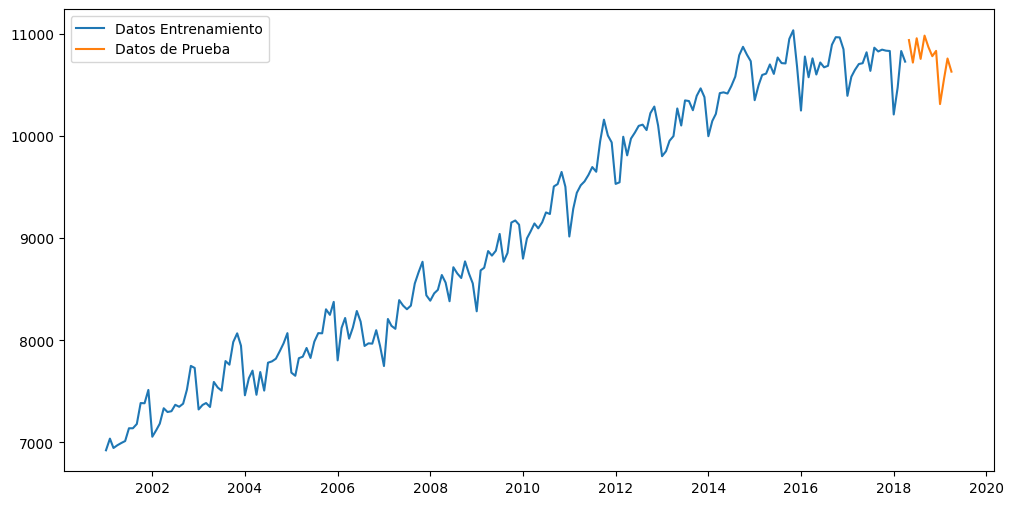

In [46]:
train_len = 208
train_Ocupados = data[["Ocupados"]][:train_len]
test_Ocupados = data[["Ocupados"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(test_td,label="Datos de Prueba")
plt.legend()
plt.show()

In [47]:
train_Ocupados

,Ocupados
mes,
2001-01-01,6923.604
2001-02-01,7037.746
2001-03-01,6945.973
2001-04-01,6973.079
2001-05-01,6994.462
...,...
2017-12-01,10834.330
2018-01-01,10212.612
2018-02-01,10476.311


In [48]:
test_Ocupados

,Ocupados
mes,
2018-05-01,10941.294
2018-06-01,10720.946
2018-07-01,10959.197
2018-08-01,10756.782
2018-09-01,10984.928
2018-10-01,10874.338
2018-11-01,10783.299
2018-12-01,10835.398
2019-01-01,10314.438


#### 5.4.1 Promedio movil

El promedio móvil está dado por:

$$ F_{t + 1}=\frac{Y_{t} + Y_{t-1} + Y_{t-(k-1)} }{ k} $$

El método de los promedios móviles utiliza el promedio de los $k$
valores de datos más recientes en la serie de tiempo como el
pronóstico para el siguiente periodo.

El término móvil indica que, mientras se dispone de una nueva
observación para la serie de tiempo, reemplaza a la observación más
antigua de la ecuación anterior y se calcula un promedio nuevo.
Como resultado, el promedio cambiará, o se moverá, conforme surjan
nuevas observaciones.

$Y_{t}$ = Observación en el período t

$F_{t}$ = Pronóstico en el período t

In [51]:
## Considerando el dato actual
ma_2= train_Ocupados.rolling(2,min_periods=2).mean()
ma_3= train_Ocupados.rolling(3,min_periods=2).mean()
ma_4= train_Ocupados.rolling(4,min_periods=2).mean()
ma_5= train_Ocupados.rolling(5,min_periods=2).mean()
ma_6= train_Ocupados.rolling(6,min_periods=2).mean()

In [52]:
## Sin considerar el dato actual
ma_2= train_Ocupados.shift().rolling(2,min_periods=2).mean()
ma_3= train_Ocupados.shift().rolling(3,min_periods=2).mean()
ma_4= train_Ocupados.shift().rolling(4,min_periods=2).mean()
ma_5= train_Ocupados.shift().rolling(5,min_periods=2).mean()
ma_6= train_Ocupados.shift().rolling(6,min_periods=2).mean()

In [53]:
def fore_ma(datos,w,h): #w es la ventana del promedio para hacer el pronostico (10,15,20,25,30) w=2 (10 con 15, 15 con 20, 20 con 25) w=3 (10 con 15 con 20, )..., h el num de pronosticos hacia adelante
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
  return data[-h:]

In [54]:
ma_2_f= fore_ma(train_td,2,12) # duda: si h es quien me mide le pronosticoa 6 meses??
ma_3_f= fore_ma(train_td,3,12)
ma_4_f= fore_ma(train_td,4,12)
ma_5_f= fore_ma(train_td,5,12)
ma_6_f= fore_ma(train_td,6,12)

In [55]:
rmse_ma_2 = np.sqrt(mean_squared_error(test_td,ma_2_f ))
rmse_ma_3 = np.sqrt(mean_squared_error(test_td,ma_3_f ))
rmse_ma_4 = np.sqrt(mean_squared_error(test_td,ma_4_f ))
rmse_ma_5 = np.sqrt(mean_squared_error(test_td,ma_5_f ))
rmse_ma_6 = np.sqrt(mean_squared_error(test_td,ma_6_f ))

In [56]:
print( rmse_ma_2, rmse_ma_3, rmse_ma_4, rmse_ma_5, rmse_ma_6)

180.61405651284463 190.8075001193029 218.76010738130725 221.86244433696749 217.677193618257


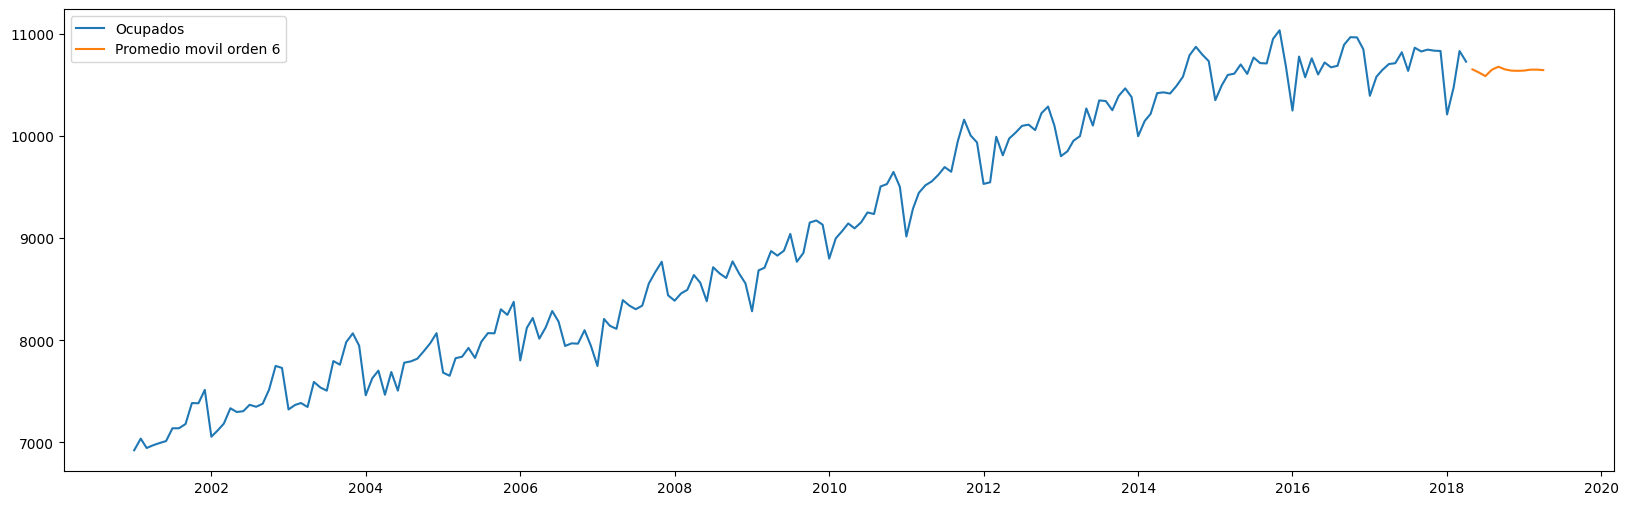

In [57]:
# Aunque en teoría nuestra mejor es el promedio movil de orden 2, por cuestion academica del ejercicio
# hacemos el de orden 6
fig = plt.figure(figsize=(20, 6))
plt.plot(train_Ocupados,label="Ocupados")
plt.plot(ma_6_f,label="Promedio movil orden 6")
plt.legend()
plt.show()

#### 5.4.2 Suavización exponencial simple

In [58]:
# Build model.
ets_model = ETSModel(endog=train_Ocupados["Ocupados"],error="add")#,trend="add",seasonal="mul" ) error: es el alfa adictivo o multiplicativo
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds = pd.concat([limits, conf_forecast], axis = 1)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

            Point_forecast      lower_95      upper_95
2018-05-01    10720.369929  10363.684215  11077.055642
2018-06-01    10720.369929  10295.289386  11145.450471
2018-07-01    10720.369929  10236.466801  11204.273056
2018-08-01    10720.369929  10184.057514  11256.682343
2018-09-01    10720.369929  10136.332451  11304.407406
2018-10-01    10720.369929  10092.223016  11348.516842
2018-11-01    10720.369929  10051.014034  11389.725823
2018-12-01    10720.369929  10012.198987  11428.540870
2019-01-01    10720.369929   9975.403586  11465.336271
2019-02-01    10720.369929   9940.341967  11500.397890
2019-03-01    10720.369929   9906.789945  11533.949912
2019-04-01    10720.369929   9874.567848  11566.172009


C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


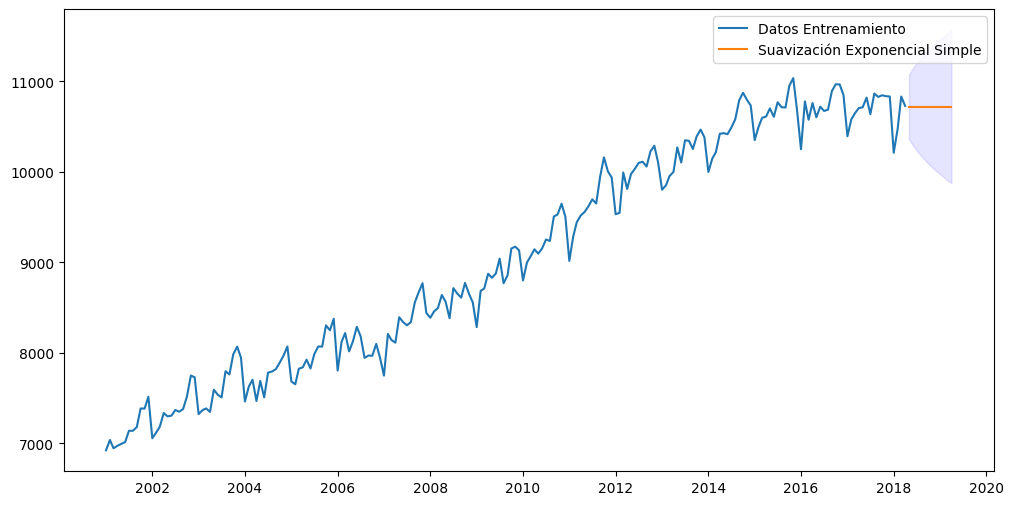

In [59]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_Ocupados,label="Datos Entrenamiento")
plt.plot(preds['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(preds.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [60]:
ets_result.alpha

0.64828262016549

In [66]:
rmse = np.sqrt(mean_squared_error(test_Ocupados,point_forecast ))
print(rmse)

268.07484226703104


En esta caso el α estimado es 0.64828262016549 y el RMSE en la muestra de evaluación es 268.07484226703104

#### 5.4.3 Suavizacion Exponencial Lineal (Holt)

In [62]:
# Build model.
ets_model = ETSModel(endog=train_Ocupados["Ocupados"],error="mul",trend="mul")#,seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_holt = pd.concat([limits, conf_forecast], axis = 1)
preds_holt.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_holt)

            Point_forecast      lower_95      upper_95
2018-05-01    10749.538767  10321.119278  11143.605527
2018-06-01    10773.218852  10301.481149  11217.014835
2018-07-01    10796.951102  10281.650414  11326.305468
2018-08-01    10820.735631  10246.801424  11354.419153
2018-09-01    10844.572555  10217.202896  11435.903077
2018-10-01    10868.461989  10185.362770  11539.657173
2018-11-01    10892.404050  10160.790672  11605.969825
2018-12-01    10916.398852  10141.211714  11659.938314
2019-01-01    10940.446512  10120.659656  11740.165120
2019-02-01    10964.547146  10105.075140  11827.614994
2019-03-01    10988.700872  10035.431746  11905.521499
2019-04-01    11012.907805  10079.915781  11981.119872


C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


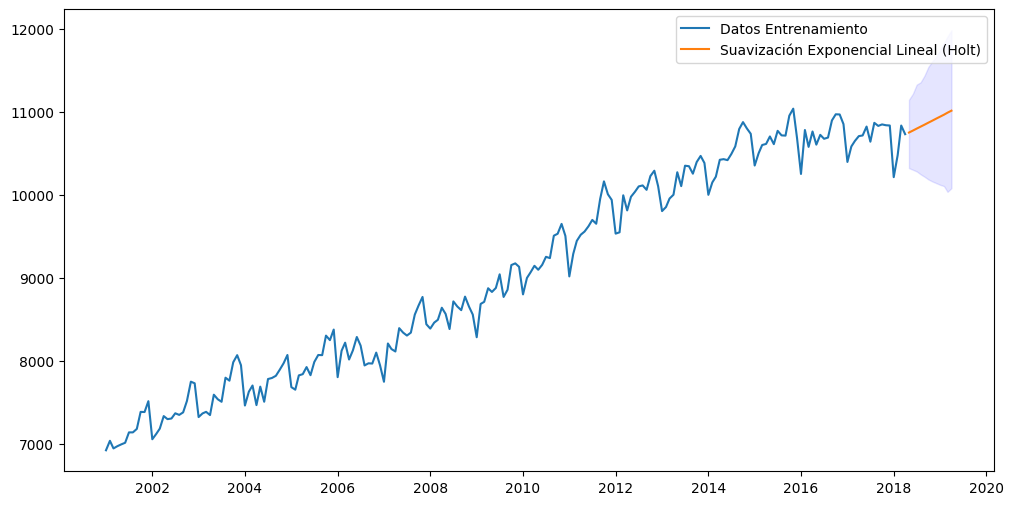

In [63]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_Ocupados,label="Datos Entrenamiento")
plt.plot(preds_holt['Point_forecast'],label="Suavización Exponencial Lineal (Holt)")
plt.fill_between(preds_holt.index ,preds_holt['lower_95'], preds_holt['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [64]:
print(ets_result.alpha,ets_result.beta)

0.561933701427309 5.619337014273091e-05


In [65]:
rmse_holt = np.sqrt(mean_squared_error(test_Ocupados,preds_holt['Point_forecast']))
print(rmse_holt)

268.07484226703104


En esta caso el α estimado es 0.561933701427309 y el β estimado es 5.619337014273091e-05. 

El RMSE en la muestra de evaluación es 268.07484226703104

#### 5.4.4 Suavizacion Exponencial Lineal de Winters (Holt-Winters)

In [67]:
# Build model Aditivo
ets_model = ETSModel(endog=train_Ocupados["Ocupados"],error="add",trend="add",seasonal="add" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

            Point_forecast      lower_95      upper_95
2018-05-01    10778.708058  10522.810656  11034.605460
2018-06-01    10842.416984  10571.477782  11113.356185
2018-07-01    10833.186676  10547.995150  11118.378201
2018-08-01    10942.058240  10643.290861  11240.825618
2018-09-01    10997.453135  10685.697988  11309.208282
2018-10-01    11095.814544  10771.589032  11420.040056
2018-11-01    11114.750563  10778.514517  11450.986609
2018-12-01    11011.755005  10663.920619  11359.589391
2019-01-01    10524.718662  10165.658183  10883.779141
2019-02-01    10802.721973  10432.773759  11172.670188
2019-03-01    10952.696353  10572.169716  11333.222989
2019-04-01    10962.090701  10571.269838  11352.911563


C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


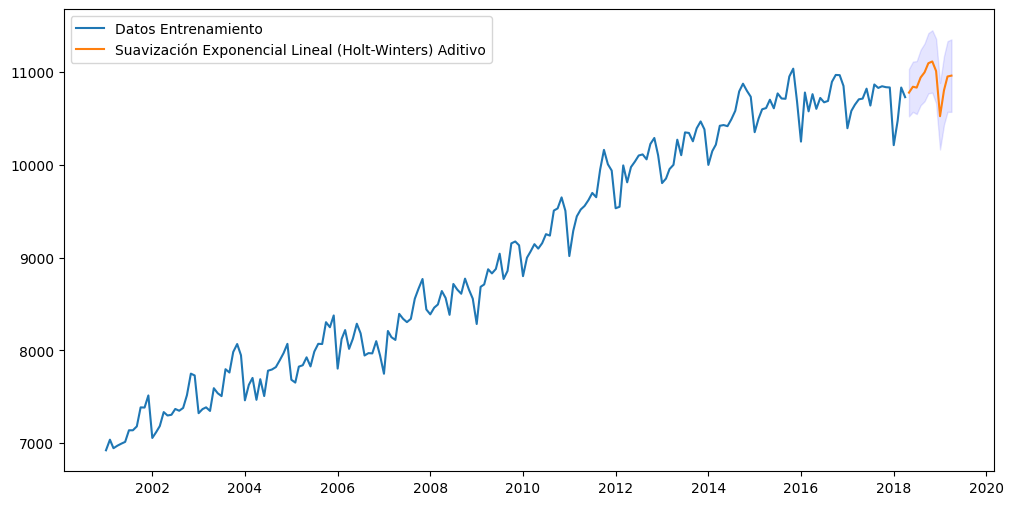

In [68]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_Ocupados,label="Datos Entrenamiento")
plt.plot(preds_hw_add['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Aditivo")
plt.fill_between(preds_hw_add.index ,preds_hw_add['lower_95'], preds_hw_add['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [72]:
print(ets_result.alpha,ets_result.beta,ets_result.gamma)

0.3478392284982235 3.478392284982235e-05 0.3221634443348571


In [73]:
rmse_hw_add = np.sqrt(mean_squared_error(test_Ocupados,preds_hw_add['Point_forecast']))
print(rmse_hw_add)

210.45351531012744


En esta caso el α estimado es 0.3478392284982235, el β estimado es 3.478392284982235e-05 y el gamma estimado es 0.3221634443348571 

El RMSE en la muestra de evaluación es 210.45351531012744

In [75]:
# Build model multiplicativo
ets_model = ETSModel(endog=train_Ocupados["Ocupados"],error="mul",trend="mul",seasonal="mul")
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_mul = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_mul.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_mul)

            Point_forecast      lower_95      upper_95
2018-05-01    10822.866381  10561.918661  11117.258541
2018-06-01    10803.806769  10507.441019  11110.480096
2018-07-01    10910.545440  10568.375832  11261.743652
2018-08-01    10913.839802  10572.426816  11287.824153
2018-09-01    10991.715755  10603.780900  11412.530850
2018-10-01    11165.578034  10718.825198  11621.680646
2018-11-01    11211.259460  10772.603259  11713.545389
2018-12-01    11118.119500  10626.524470  11622.014203
2019-01-01    10650.688465  10171.083822  11146.362264
2019-02-01    10870.800892  10383.331891  11391.981361
2019-03-01    10965.074602  10439.090417  11531.752308
2019-04-01    10985.918034  10442.384304  11568.433582


C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


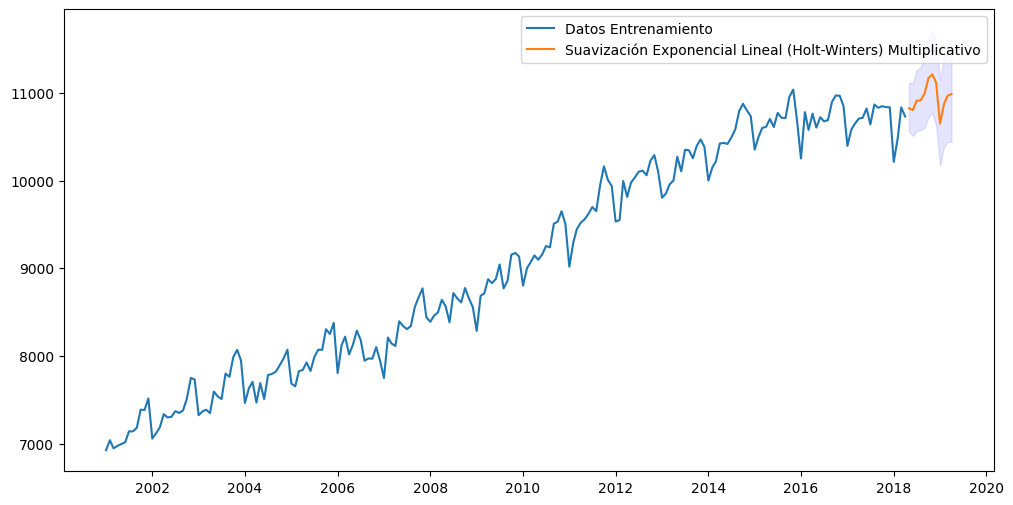

In [76]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_Ocupados,label="Datos Entrenamiento")
plt.plot(preds_hw_mul['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Multiplicativo")
plt.fill_between(preds_hw_mul.index ,preds_hw_mul['lower_95'], preds_hw_mul['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [77]:
print(ets_result.alpha,ets_result.beta,ets_result.gamma)

0.5527464221886013 5.527464221886013e-05 4.4725357781139875e-05


In [78]:
rmse_hw_mul = np.sqrt(mean_squared_error(test_Ocupados,preds_hw_mul['Point_forecast']))
print(rmse_hw_mul)

253.93738539827106


En esta caso el α estimado es 0.5527464221886013, el β estimado es 5.527464221886013e-05 y el gamma estimado es 4.4725357781139875e-05

El RMSE en la muestra de evaluación es 253.93738539827106

# Aquí vamos, ahora a hacer los modelos y guardar los resultados

Ahora vamos a realizar los diferentes modelos para compararlos y determinar el mejor de ellos en un promedio movil de orden 6